# NextHikes :- Rossmann Pharmaceutical Sales prediction across multiple stores

## Import Libraries  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

--------------

# Task 2 - Prediction of store sales

Prediction of sales is the central task in this challenge. you want to predict daily sales in various stores up to 6 weeks ahead of time. This will help the company plan ahead of time. 

## Load Data

In [3]:
store_data = pd.read_csv("store.csv")

In [4]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
store_data.shape

(1115, 10)

In [6]:
store_data.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
train_data = pd.read_csv("train.csv")

In [8]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
train_data.shape

(1017209, 9)

In [10]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [11]:
test_data = pd.read_csv("test.csv")

In [12]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [13]:
test_data.shape

(41088, 8)

In [14]:
test_data.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

-----------

## Task - 2.1 Preprocessing

It is important to process the data into a format where it can be fed to a machine learning model. This typically means converting all non-numeric columns to numeric, handling NaN values and generating new features from already existing features. 

In our case, you have a few datetime columns to preprocess. you can extract the following from them:
-	weekdays
-	weekends 
-	number of days to holidays
-	Number of days after holiday
-	Beginning of month, mid month and ending of month
-	(think of more features to extract), extra marks for it
			
As a final thing, you have to scale the data. This helps with predictions especially when using machine learning algorithms that use Euclidean distances. you can use the standard scaler in sklearn for this.


In [15]:
# Merging "store_data" with "train_data"
merged_train_data = train_data.merge(store_data, on='Store', how='left')

# Merging "store_data" with "test_data"
merged_test_data = test_data.merge(store_data, on='Store', how='left')

In [16]:
merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [17]:
merged_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

In [18]:
# Converting the date column to datetime format

merged_train_data['Date'] = pd.to_datetime(merged_train_data['Date'])
merged_test_data['Date'] = pd.to_datetime(merged_test_data['Date'])

In [19]:
merged_train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [20]:
merged_test_data.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000,40992.000000,25872.000000,25872.000000,41088.000000,23856.000000,23856.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487,5088.583138,7.035250,2008.641929,0.580607,24.426559,2011.820926
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802,7225.487467,3.143015,6.862400,0.493466,14.161312,1.692166
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,720.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,2425.000000,7.000000,2010.000000,1.000000,22.000000,2012.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000,6480.000000,9.000000,2012.000000,1.000000,37.000000,2013.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,49.000000,2015.000000


In [21]:
# Extract features from datetime for train data
merged_train_data['weekday'] = merged_train_data['Date'].dt.weekday
merged_train_data['is_weekend'] = merged_train_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Extract features from datetime for test data
merged_test_data['weekday'] = merged_test_data['Date'].dt.weekday
merged_test_data['is_weekend'] = merged_test_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [22]:
merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [23]:
merged_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int64         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41077 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   StateHoliday               41088 non-null  object        
 7   SchoolHoliday              41088 non-null  int64         
 8   StoreType                  41088 non-null  object        
 9   Assortment                 41088 non-null  object        
 10  CompetitionDistance        40992 non-null  float64       
 11  CompetitionOpenSinceMonth  25872 non-null  float64       
 12  Comp

In [24]:
# Create a new column SalesPerCustomer
merged_train_data['SalesPerCustomer'] = merged_train_data['Sales'] / merged_train_data['Customers']

In [25]:
# Create a function "get_season" for merged_train_data
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

merged_train_data['Season'] = merged_train_data['Date'].dt.month.apply(get_season)

# Create a function "get_season" for merged_test_data
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

merged_test_data['Season'] = merged_test_data['Date'].dt.month.apply(get_season)

In [26]:
holiday_dates = [
    pd.to_datetime('2023-01-01'),
    pd.to_datetime('2023-04-15'),
    pd.to_datetime('2023-07-04'),
    pd.to_datetime('2023-12-25')]

In [27]:
merged_train_data['IsBeginningOfMonth'] = (merged_train_data['Date'].dt.day <= 10).astype(int)
merged_train_data['IsMidOfMonth'] = ((merged_train_data['Date'].dt.day > 10) & (merged_train_data['Date'].dt.day <= 20)).astype(int)
merged_train_data['IsEndOfMonth'] = (merged_train_data['Date'].dt.day > 20).astype(int)

merged_test_data['IsBeginningOfMonth'] = (merged_test_data['Date'].dt.day <= 10).astype(int)
merged_test_data['IsMidOfMonth'] = ((merged_test_data['Date'].dt.day > 10) & (merged_test_data['Date'].dt.day <= 20)).astype(int)
merged_test_data['IsEndOfMonth'] = (merged_test_data['Date'].dt.day > 20).astype(int)


In [28]:
# Calculate days to and after holidays
merged_train_data['DaysToHoliday'] = ((holiday_dates[0] - merged_train_data['Date']).dt.days).clip(lower=0)
merged_train_data['DaysAfterHoliday'] = ((merged_train_data['Date'] - holiday_dates[-1]).dt.days).clip(lower=0)

merged_test_data['DaysToHoliday'] = ((holiday_dates[0] - merged_test_data['Date']).dt.days).clip(lower=0)
merged_test_data['DaysAfterHoliday'] = ((merged_test_data['Date'] - holiday_dates[-1]).dt.days).clip(lower=0)

In [29]:
# Defining a function to separate categorical and numerical data
def separate_categorical_and_continious(data):
    categorical_cols, numerical_cols = [] , []
    for cols in data.columns:
        if data[cols].dtypes == "object":
            categorical_cols.append(cols)
        else:
            numerical_cols.append(cols)
    return categorical_cols, numerical_cols

# Separating categorical and numerical data from train and test data
categorical_cols_train, numerical_cols_train = separate_categorical_and_continious(merged_train_data)
categorical_cols_test, numerical_cols_test = separate_categorical_and_continious(merged_test_data)

In [30]:
categorical_cols_train, numerical_cols_train

(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'Season'],
 ['Store',
  'DayOfWeek',
  'Date',
  'Sales',
  'Customers',
  'Open',
  'Promo',
  'SchoolHoliday',
  'CompetitionDistance',
  'CompetitionOpenSinceMonth',
  'CompetitionOpenSinceYear',
  'Promo2',
  'Promo2SinceWeek',
  'Promo2SinceYear',
  'weekday',
  'is_weekend',
  'SalesPerCustomer',
  'IsBeginningOfMonth',
  'IsMidOfMonth',
  'IsEndOfMonth',
  'DaysToHoliday',
  'DaysAfterHoliday'])

In [31]:
categorical_cols_test, numerical_cols_test

(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'Season'],
 ['Id',
  'Store',
  'DayOfWeek',
  'Date',
  'Open',
  'Promo',
  'SchoolHoliday',
  'CompetitionDistance',
  'CompetitionOpenSinceMonth',
  'CompetitionOpenSinceYear',
  'Promo2',
  'Promo2SinceWeek',
  'Promo2SinceYear',
  'weekday',
  'is_weekend',
  'IsBeginningOfMonth',
  'IsMidOfMonth',
  'IsEndOfMonth',
  'DaysToHoliday',
  'DaysAfterHoliday'])

In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

merged_train_data['StoreType'] = encoder.fit_transform(merged_train_data['StoreType'])
merged_train_data['StateHoliday'] = merged_train_data['StateHoliday'].astype(str)
merged_train_data['StateHoliday'] = encoder.fit_transform(merged_train_data['StateHoliday'])
merged_train_data['Assortment'] = encoder.fit_transform(merged_train_data['Assortment'])
merged_train_data['PromoInterval'] = encoder.fit_transform(merged_train_data['PromoInterval'])
merged_train_data['Season'] = encoder.fit_transform(merged_train_data['Season'])

merged_test_data['StoreType'] = encoder.fit_transform(merged_test_data['StoreType'])
merged_test_data['StateHoliday'] = merged_test_data['StateHoliday'].astype(str)
merged_test_data['StateHoliday'] = encoder.fit_transform(merged_test_data['StateHoliday'])
merged_test_data['Assortment'] = encoder.fit_transform(merged_test_data['Assortment'])
merged_test_data['PromoInterval'] = encoder.fit_transform(merged_test_data['PromoInterval'])
merged_test_data['Season'] = encoder.fit_transform(merged_test_data['Season'])


In [33]:
merged_train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'weekday', 'is_weekend',
       'SalesPerCustomer', 'Season', 'IsBeginningOfMonth', 'IsMidOfMonth',
       'IsEndOfMonth', 'DaysToHoliday', 'DaysAfterHoliday'],
      dtype='object')

In [34]:
merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int32         
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  int32         
 10  Assortment                 1017209 non-null  int32         
 11  CompetitionDistance        1014567 no

In [35]:
merged_train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,weekday,is_weekend,SalesPerCustomer,Season,IsBeginningOfMonth,IsMidOfMonth,IsEndOfMonth,DaysToHoliday,DaysAfterHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,844340.000000,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209.0
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,4.516279e-02,1.786467e-01,1.207467e+00,9.351412e-01,...,1.978094e+00,2.998341e+00,2.845630e-01,9.493619,1.587168e+00,3.291841e-01,3.291851e-01,3.416309e-01,3.186937e+03,0.0
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,2.836559e-01,3.830564e-01,1.365376e+00,9.938011e-01,...,1.119589e+00,1.997391e+00,4.512063e-01,2.197494,1.059326e+00,4.699172e-01,4.699175e-01,4.742567e-01,2.744541e+02,0.0
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.711000e+03,0.0
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,7.895563,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.942000e+03,0.0
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,3.000000e+00,0.000000e+00,9.250000,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.196000e+03,0.0
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,2.000000e+00,...,3.000000e+00,5.000000e+00,1.000000e+00,10.899729,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.424000e+03,0.0
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,...,3.000000e+00,6.000000e+00,1.000000e+00,64.957854,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.652000e+03,0.0


In [36]:
merged_test_data.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'weekday',
       'is_weekend', 'Season', 'IsBeginningOfMonth', 'IsMidOfMonth',
       'IsEndOfMonth', 'DaysToHoliday', 'DaysAfterHoliday'],
      dtype='object')

In [37]:
merged_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int64         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41077 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   StateHoliday               41088 non-null  int32         
 7   SchoolHoliday              41088 non-null  int64         
 8   StoreType                  41088 non-null  int32         
 9   Assortment                 41088 non-null  int32         
 10  CompetitionDistance        40992 non-null  float64       
 11  CompetitionOpenSinceMonth  25872 non-null  float64       
 12  Comp

In [38]:
merged_test_data.describe()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2SinceYear,PromoInterval,weekday,is_weekend,Season,IsBeginningOfMonth,IsMidOfMonth,IsEndOfMonth,DaysToHoliday,DaysAfterHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,40992.000000,...,23856.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.0
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.004381,0.443487,1.252336,1.001168,5088.583138,...,2011.820926,1.806075,2.979167,0.291667,0.645833,0.416667,0.354167,0.229167,2686.500000,0.0
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.066044,0.496802,1.397401,0.994741,7225.487467,...,1.692166,1.128349,2.015481,0.454535,0.478266,0.493013,0.478266,0.420302,13.853568,0.0
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,...,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2663.000000,0.0
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,720.000000,...,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2674.750000,0.0
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2425.000000,...,2012.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2686.500000,0.0
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,0.000000,1.000000,3.000000,2.000000,6480.000000,...,2013.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2698.250000,0.0
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,75860.000000,...,2015.000000,3.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2710.000000,0.0


In [39]:
# Drop columns from merged_train_data
merged_train_data.drop(columns=['Sales', 'Customers'], inplace=True)

# Drop columns from merged_test_data
merged_test_data.drop(columns=['Id'], inplace=True)


In [40]:
merged_train_data.set_index('Date', inplace=True)
merged_train_data.sort_index(inplace=True)

merged_test_data.set_index('Date', inplace=True)
merged_test_data.sort_index(inplace=True)

In [41]:
# Scale the data using StandardScaler for both train and test data
scaler = StandardScaler()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

merged_train_data_scalerd = scaler.fit_transform(merged_train_data)
merged_test_data_scalerd = scaler.fit_transform(merged_test_data)

----------------

## Task - 2.2 Building models with sklearn pipelines

In [42]:
merged_train_data.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'weekday',
       'is_weekend', 'SalesPerCustomer', 'Season', 'IsBeginningOfMonth',
       'IsMidOfMonth', 'IsEndOfMonth', 'DaysToHoliday', 'DaysAfterHoliday'],
      dtype='object')

In [43]:
# Separate features and target variable

X = merged_train_data[['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                      'StoreType', 'Assortment', 'CompetitionDistance',
                      'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                      'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'weekday',
                      'is_weekend', 'Season', 'IsBeginningOfMonth',
                      'IsMidOfMonth', 'IsEndOfMonth', 'DaysToHoliday', 'DaysAfterHoliday']]
y = merged_train_data['SalesPerCustomer']

In [44]:
# Create teh train and test splits 
split_size = int(0.8 * len(y)) # 80 % for training

# Create train data splits
X_train, y_train = X[:split_size], y[:split_size]

# Create the test split
X_test, y_test = X[split_size:], y[split_size:]

print('X_Train shape:',X_train.shape)
print('X_Test shape:',X_test.shape)
print('Y_Train shape:',y_train.shape)
print('Y_Test shape:',y_test.shape)

X_Train shape: (813767, 23)
X_Test shape: (203442, 23)
Y_Train shape: (813767,)
Y_Test shape: (203442,)


In [45]:
# Making separate lists for categorical and numerical columns
categorical_cols, numerical_cols = [], []

for i in merged_train_data.columns:
    print("The datatype for {} is {}".format(i,merged_train_data[i].dtypes))
    # check if the datatype is object or not
    if merged_train_data[i].dtypes == "object":
        # if the datatype is object : --> fillna with mode of that column
        mode_value = merged_train_data[i].mode()[0]
        merged_train_data[i].fillna(mode_value, inplace = True)
    elif merged_train_data[i].dtypes != "object":
        # if data[i].dtypes == "bool":
        #     data[i].fillna(0, inplace = True)
        # else:
        # else if the datatype is numerical : --> fillna with mean of that column
        mean_value = merged_train_data[i].mean()
        merged_train_data[i].fillna(mean_value, inplace = True)

The datatype for Store is int64
The datatype for DayOfWeek is int64
The datatype for Open is int64
The datatype for Promo is int64
The datatype for StateHoliday is int32
The datatype for SchoolHoliday is int64
The datatype for StoreType is int32
The datatype for Assortment is int32
The datatype for CompetitionDistance is float64
The datatype for CompetitionOpenSinceMonth is float64
The datatype for CompetitionOpenSinceYear is float64
The datatype for Promo2 is int64
The datatype for Promo2SinceWeek is float64
The datatype for Promo2SinceYear is float64
The datatype for PromoInterval is int32
The datatype for weekday is int64
The datatype for is_weekend is int64
The datatype for SalesPerCustomer is float64
The datatype for Season is int32
The datatype for IsBeginningOfMonth is int32
The datatype for IsMidOfMonth is int32
The datatype for IsEndOfMonth is int32
The datatype for DaysToHoliday is int64
The datatype for DaysAfterHoliday is int64


In [46]:
# Making separate lists for categorical and numerical columns
categorical_cols, numerical_cols = [], []

for i in merged_test_data.columns:
    print("The datatype for {} is {}".format(i,merged_test_data[i].dtypes))
    # check if the datatype is object or not
    if merged_test_data[i].dtypes == "object":
        # if the datatype is object : --> fillna with mode of that column
        mode_value = merged_test_data[i].mode()[0]
        merged_test_data[i].fillna(mode_value, inplace = True)
    elif merged_test_data[i].dtypes != "object":
        mean_value = merged_test_data[i].mean()
        merged_test_data[i].fillna(mean_value, inplace = True)

The datatype for Store is int64
The datatype for DayOfWeek is int64
The datatype for Open is float64
The datatype for Promo is int64
The datatype for StateHoliday is int32
The datatype for SchoolHoliday is int64
The datatype for StoreType is int32
The datatype for Assortment is int32
The datatype for CompetitionDistance is float64
The datatype for CompetitionOpenSinceMonth is float64
The datatype for CompetitionOpenSinceYear is float64
The datatype for Promo2 is int64
The datatype for Promo2SinceWeek is float64
The datatype for Promo2SinceYear is float64
The datatype for PromoInterval is int32
The datatype for weekday is int64
The datatype for is_weekend is int64
The datatype for Season is int32
The datatype for IsBeginningOfMonth is int32
The datatype for IsMidOfMonth is int32
The datatype for IsEndOfMonth is int32
The datatype for DaysToHoliday is int64
The datatype for DaysAfterHoliday is int64


In [47]:
merged_test_data.isnull().sum()

Store                        0
DayOfWeek                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
weekday                      0
is_weekend                   0
Season                       0
IsBeginningOfMonth           0
IsMidOfMonth                 0
IsEndOfMonth                 0
DaysToHoliday                0
DaysAfterHoliday             0
dtype: int64

In [48]:
# Define X and y
X = merged_train_data[['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                      'StoreType', 'Assortment', 'CompetitionDistance',
                      'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                      'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'weekday',
                      'is_weekend', 'Season', 'IsBeginningOfMonth',
                      'IsMidOfMonth', 'IsEndOfMonth', 'DaysToHoliday', 'DaysAfterHoliday']]
y = merged_train_data['SalesPerCustomer']

In [49]:
from sklearn.linear_model import LinearRegression
X_train = merged_train_data.dropna(subset=X.columns)
y_train = X_train['SalesPerCustomer']
X_train = X_train.drop(columns=['SalesPerCustomer'])

In [50]:
# Define the imputer and regressor
imputer = SimpleImputer(strategy='mean')
regressor = LinearRegression()

# Create a pipeline
pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('regressor', regressor)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)

# Predict using the fitted pipeline
y_pred = pipeline.predict(X_test)
y_pred

array([ 9.03149791,  9.29247974, 10.09594748, ..., 11.25142567,
       10.94472368, 10.12467477])

In [51]:
# Calculate the mean squared error
lr_mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", lr_mse)

Mean Squared Error: 2.8541690448512873


---------

## Task - 2.3 Choose a loss function

#### Deep Learning - Neural Network:

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))





Epoch 1/10

25431/25431 [==============================] - 68s 3ms/step - loss: 61.6735 - val_loss: 3.1837
Epoch 2/10
25431/25431 [==============================] - 67s 3ms/step - loss: 2.8425 - val_loss: 2.5302
Epoch 3/10
25431/25431 [==============================] - 66s 3ms/step - loss: 2.4654 - val_loss: 2.2673
Epoch 4/10
25431/25431 [==============================] - 65s 3ms/step - loss: 2.3721 - val_loss: 2.5097
Epoch 5/10
25431/25431 [==============================] - 66s 3ms/step - loss: 2.2626 - val_loss: 2.1444
Epoch 6/10
25431/25431 [==============================] - 65s 3ms/step - loss: 2.1689 - val_loss: 2.0064
Epoch 7/10
25431/25431 [==============================] - 65s 3ms/step - loss: 2.1383 - val_loss: 2.1155
Epoch 8/10
25431/25431 [==============================] - 65s 3ms/step - loss: 2.1168 - val_loss: 2.0436
Epoch 9/10
25431/25431 [==============================] - 63s 2ms/step - loss: 2.0845 - val_loss: 2.0605
Epoch 10/10
25431/25431 [=========================

In [53]:
# Evaluate the model on the test dataset
test_acc = model.evaluate(X_test, y_test)
test_loss = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

6358/6358 [==============================] - 11s 2ms/step - loss: 1.9739
Test Accuracy: 1.97
Test Loss: 1.97


In [54]:
# Predict using the trained model
y_pred_rnn = model.predict(X_test)

# Calculate MSE
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
print("Mean Squared Error (RNN):", mse_rnn)

6358/6358 [==============================] - 10s 2ms/step
Mean Squared Error (RNN): 1.9738995141641869


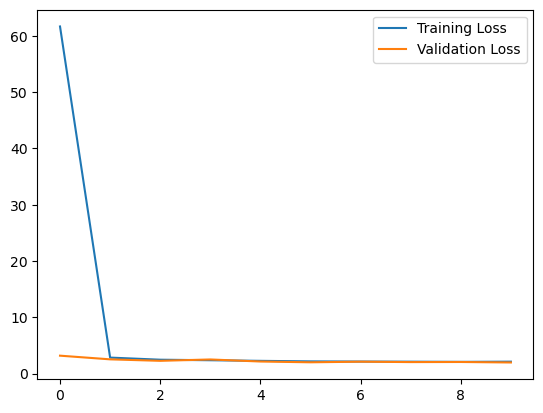

In [55]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#### Deep Learning - LSTM:

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np


X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)  
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mse')

# Train the model
history = model_lstm.fit(X_train_lstm, y_train, epochs=5, batch_size=128, validation_data=(X_test_lstm, y_test))

Epoch 1/5
6358/6358 [==============================] - 207s 32ms/step - loss: 719.5395 - val_loss: 9.0306
Epoch 2/5
6358/6358 [==============================] - 187s 29ms/step - loss: 6.2915 - val_loss: 4.5323
Epoch 3/5
6358/6358 [==============================] - 171s 27ms/step - loss: 4.5814 - val_loss: 4.2242
Epoch 4/5
6358/6358 [==============================] - 171s 27ms/step - loss: 12.1221 - val_loss: 2.7660
Epoch 5/5
6358/6358 [==============================] - 173s 27ms/step - loss: 95.2917 - val_loss: 2.2507


In [58]:
# Predict using the trained LSTM model
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Calculate MSE
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print("Mean Squared Error (LSTM):", mse_lstm)


6358/6358 [==============================] - 48s 7ms/step
Mean Squared Error (LSTM): 2.250698397733097


-----------------

## Task - 2.4 Post Prediction analysis

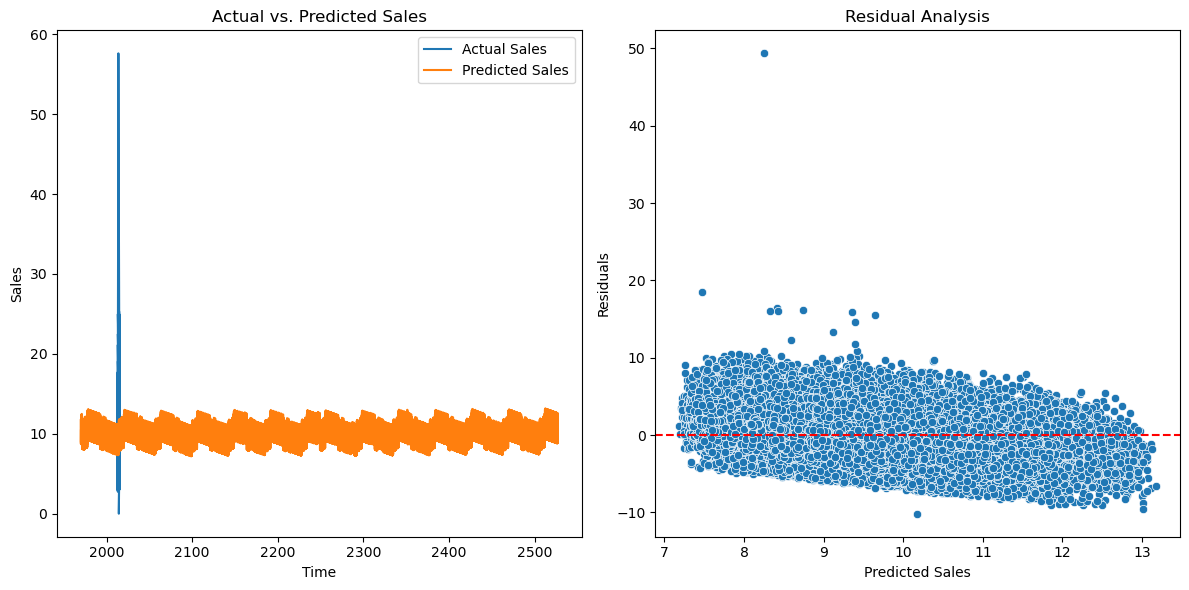

MAE for Store Type '0': 1.8149823144185644
MAE for Store Type '1': 1.8149823144185644
MAE for Store Type '2': 1.8149823144185644
MAE for Store Type '3': 1.8149823144185644


In [59]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Visualize predictions and residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label="Actual Sales")
plt.plot(y_pred, label="Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("Actual vs. Predicted Sales")
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residual Analysis")

plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error
# Segment analysis (example)
store_type_segments = merged_train_data.groupby('StoreType')
for store_type, group in store_type_segments:
    segment_mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE for Store Type '{store_type}': {segment_mae}")


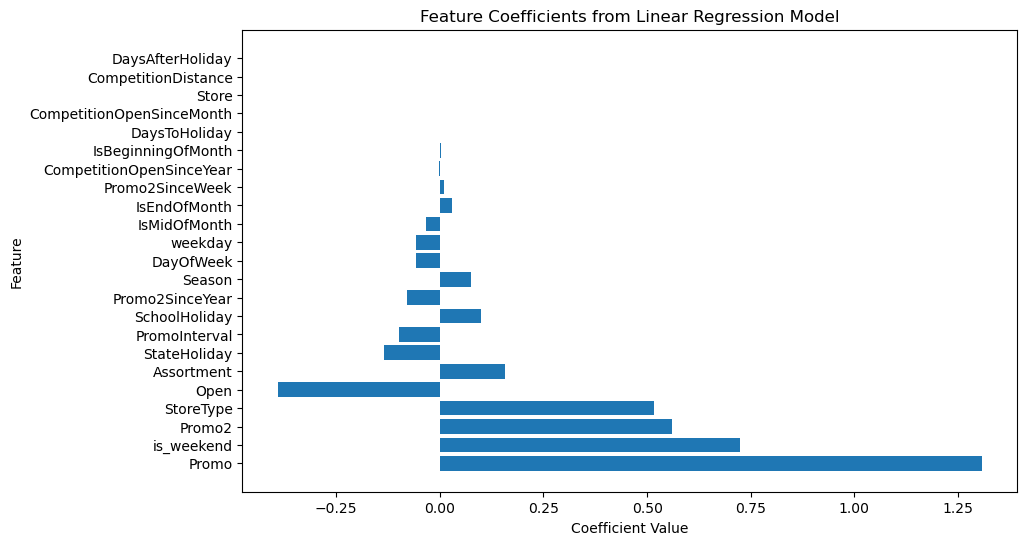

Feature Coefficients:
                      Feature  Coefficient  Abs_Coefficient
3                       Promo     1.308197         1.308197
16                 is_weekend     0.723908         0.723908
11                     Promo2     0.559127         0.559127
6                   StoreType     0.517099         0.517099
2                        Open    -0.391298         0.391298
7                  Assortment     0.158227         0.158227
4                StateHoliday    -0.134922         0.134922
14              PromoInterval    -0.098270         0.098270
5               SchoolHoliday     0.098118         0.098118
13            Promo2SinceYear    -0.078952         0.078952
17                     Season     0.074176         0.074176
1                   DayOfWeek    -0.057332         0.057332
15                    weekday    -0.057332         0.057332
19               IsMidOfMonth    -0.033203         0.033203
20               IsEndOfMonth     0.030461         0.030461
12            Prom

In [60]:
from sklearn.linear_model import LinearRegression

# Define features and target
features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'weekday',
       'is_weekend',  'Season', 'IsBeginningOfMonth',
       'IsMidOfMonth', 'IsEndOfMonth', 'DaysToHoliday', 'DaysAfterHoliday']
target = 'SalesPerCustomer'

# Assuming merged_train_data contains your preprocessed data
train_features = merged_train_data[features]
train_labels = merged_train_data[target]

# Train a Linear Regression model
model = LinearRegression()
model.fit(train_features, train_labels)

# Retrieve coefficients (weights) and intercept
coefficients = model.coef_
intercept = model.intercept_

# Create a DataFrame to hold feature names and their coefficients
coefficient_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Sort features by coefficient magnitude
coefficient_df['Abs_Coefficient'] = coefficient_df['Coefficient'].abs()
coefficient_df = coefficient_df.sort_values(by='Abs_Coefficient', ascending=False)

# Visualize feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficient_df['Feature'], coefficient_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients from Linear Regression Model')
plt.show()

print("Feature Coefficients:")
print(coefficient_df)
print("Intercept:", intercept)


In [61]:
merged_train_data.to_csv("train_df.csv")
merged_test_data.to_csv("test_df.csv")

----------------

## Task - 2.5 Serialize models

In [63]:
import pickle
from datetime import datetime

# Save the model with a timestamp in the filename
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename_Rossmann_Pharmaceuticals = f'linear_regression_model_{timestamp}.pkl'

with open(filename_Rossmann_Pharmaceuticals, 'wb') as file:
    pickle.dump(model, file)

# Load the model from the file
with open(filename_Rossmann_Pharmaceuticals, 'rb') as file:
    loaded_model = pickle.load(file)
